# Modeling SNAP Policy Generosity Across U.S States

##### By: By: Shawn Ding, Grace George, Razan Habboub, Arnav Jain, Aeon Levy
Click [Here](https://github.com/arnavjain321-prog/DS_6021_Final_Project) to acess our Project GitHub

# Ⅰ. Introduction & Project Overview

SNAP is one of the main safety-net programs in the US, but states differ substantially by how generous their SNAP benefits.

Our project looks at SNAP (Supplemental Nutrition Assistance Program) across the  U.S. 

We want to construct a state-level dataset combining SNAP benefits, social inequality, income, food price indices, demographics, and policy variables to better understand the concept of **SNAP Policy Generosity**. 

   ### ✶ Reseach Question(s) and Motavations  ✶

We want to understand what factors drive differences in SNAP allocation and how these patterns could inform policymakers.

- Goal: Highlight associations in SNAP generosity across states.

- Motivation: Support future empirical research on social safety nets and guide evidence-based policy decisions.

Scope & Limitations

- The analysis is cross-sectional and descriptive; we do not infer causality.

- Focus is on patterns and associations, not on predicting individual outcomes or making policy recommendations directly.


**We focus on three main questions...**


1. How can we construct a consistent, state-level measure of SNAP generosity?

    -We use participants per 1,000 residents and per-person benefit levels as core indicators of program reach and generosity.

2. How do economic, demographic, and policy environments relate to SNAP generosity?

    -We combine poverty, income, grocery cost indices, racial composition, minimum wage tier, political trifecta status, etc...into a single modeling dataset.

3. Can we predict whether states fall into Low, Moderate, or High SNAP generosity classes?

    -We use several predictive methods and models to assess how well observable features classify.


*Note ~ Our analysis is cross-sectional and descriptive, so we do not claim causality. Our aim is to highlight patterns and associations*

   ### ✶ Selecting the Data ✶

We build a state-level dataset by merging the following sources:

- **ACS 2024 – Race (Table B02001):**  
  Total population and race counts, used to compute race shares by state.

- **ACS 2024 – Median Household Income (Table B19013):**  
  State-level median household income.

- **ACS 2024 – Poverty (Table S1701):**  
  Share of the population below the poverty line.

- **USDA SNAP Benefits & Participants (May 2025):**  
  State-level total SNAP benefits and number of participants.

- **BLS Regional Price Parities – Food-at-Home (RPP):**  
  State-level index of grocery cost (food-at-home price parity).

- **USDA SNAP Regions:**  
  Assignment of states to SNAP regional offices.

- **State Trifecta Control (2024):**  
  Whether each state is under Democratic, Republican, or divided trifecta control.

- **State Minimum Wage (2025):**  
  State-level minimum wage and a derived wage tier (low / medium / high).

- **Rural–Urban Continuum Codes (RUCC 2023):**  
  County-level RUCC codes aggregated to median RUCC by state and collapsed into 
  an urban / mixed / rural category.


---------------------------------------------------------------------------------

# 𝟚. Engineering and Cleaning the Data


### ✶ Our Derived Variables ✶
**The Key variables used in our modeling...**


Target Variable(Categorical):
  - `snap_policy_class` (Low, Moderate, High) based on per-person SNAP benefits.


Categorical Predictors:
  - `min_wage_tier` (low / medium / high)
  - `trifecta_2024` (Democratic / Republican / Divided)
  - `rural_urban_category` (urban / mixed / rural)
  - `usda_snap_region` (USDA SNAP region labels)


Core Numeric Predictors:
  - `benefits_per_person`
  - `participants_per_1000`
  - `poverty_rate`
  - `grocery_cost_index`
  - `median_household_income`

Additional Demographic Predictors (Numerical):
  - `white_pct`, 
  -`black_pct`, 
  -`native_pct`, 
  -`asian_pct`, `pacific_pct`, 
  -`two_plus_pct`


*Note ~ We treat race as numeric percentage variables, not as a single majority-race label, to preserve more information for modeling*


#EDIT 
From these raw sources, we constructed...

- **benefits_per_person** – May 2025 SNAP benefits divided by participants  
- **participants_per_1000** – SNAP participants per 1,000 residents  
- **grocery_cost_index** – 2023 food-at-home RPP value for each state  
- **poverty_rate** – ACS poverty share (proportion)  
- **median_household_income** – ACS median household income (USD)  
- **Race shares** – `white_pct`, `black_pct`, `native_pct`, `asian_pct`, 
  `pacific_pct`, `two_plus_pct`  
- **Policy and geography** – `min_wage_tier`, `trifecta_2024`, 
  `rural_urban_category`, `usda_snap_region`





### ✶ Final Outcome: SNAP Policy Class ✶

We create a categorical target variable, **`snap_policy_class`**, that groups states 
into three SNAP generosity classes based on **SNAP participants per 1,000 residents**:

- **Low:** Below the 33rd percentile of `participants_per_1000`  
- **Moderate:** Between the 33rd and 66th percentiles  
- **High:** At or above the 66th percentile  

The final modeling dataset has **51 rows (50 states + DC)** and a combined set of economic, demographic, and policy features for each state.

### ✶ Cleaning/Building Our Data ✶

In [1480]:
# ============================================
# Imports and directory setup
# ============================================

from pathlib import Path

import numpy as np
import pandas as pd

from pandas.errors import ParserError

# For modeling and visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Base project directory = folder where this notebook lives
PROJECT_DIR = Path.cwd()
RAW_DIR = PROJECT_DIR / "raw"
PROCESSED_DIR = PROJECT_DIR / "processed"

print("Project directory:", PROJECT_DIR)
print("Raw data directory:", RAW_DIR)
print("Processed data directory:", PROCESSED_DIR)
print("\nDirectory existence check:")
print("RAW_DIR exists:", RAW_DIR.exists())
print("PROCESSED_DIR exists:", PROCESSED_DIR.exists())


Project directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project
Raw data directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project/raw
Processed data directory: /Users/aeonlevy/Desktop/UVA_MATS/Engineering/Project_Mats/DS_6021_Final_Project/processed

Directory existence check:
RAW_DIR exists: True
PROCESSED_DIR exists: True


In [1481]:
# ============================================
# Load raw CSV data robustly
# ============================================

data_paths = {
    "acs_race":       RAW_DIR / "ACSDT1Y2024.B02001-Data.csv",
    "acs_income":     RAW_DIR / "ACSDT1Y2024.B19013-Data.csv",
    "acs_poverty":    RAW_DIR / "ACSST1Y2024.S1701-Data.csv",
    "snap_benefits":  RAW_DIR / "snap-benefits-8.csv",
    "snap_persons":   RAW_DIR / "snap-persons-8.csv",
    "state_trifecta": RAW_DIR / "state_trifecta_2024.csv",
    "snap_regions":   RAW_DIR / "usda_snap_regions.csv",
    "rpp":            RAW_DIR / "SARPP_STATE_2008_2023.csv",
    "rural_raw":      RAW_DIR / "Ruralurbancontinuumcodes2023.csv",
    "state_min_wage": RAW_DIR / "state_minimum_wage_2025.csv",
}

dfs = {}

for name, path in data_paths.items():
    try:
        df = pd.read_csv(path, dtype=str, encoding_errors="replace")
        sep_used = ","
    except ParserError:
        try:
            df = pd.read_csv(path, dtype=str, sep="\t", encoding_errors="replace")
            sep_used = "\\t (tab)"
        except Exception as e:
            print(f"!! {name:15s} FAILED to load from {path.name}: {e}")
            continue
    except FileNotFoundError:
        print(f"!! {name:15s} NOT FOUND at {path}")
        continue

    dfs[name] = df
    print(f"{name:15s} loaded from {path.name:35s} sep={sep_used} -> shape {df.shape}")

# Unpack for convenience
acs_race_raw   = dfs.get("acs_race")
acs_income_raw = dfs.get("acs_income")
acs_poverty_raw= dfs.get("acs_poverty")
snap_benefits_raw = dfs.get("snap_benefits")
snap_persons_raw  = dfs.get("snap_persons")
state_trifecta_raw= dfs.get("state_trifecta")
snap_regions_raw  = dfs.get("snap_regions")
rpp_raw           = dfs.get("rpp")
rural_raw         = dfs.get("rural_raw")
state_min_wage_raw= dfs.get("state_min_wage")


acs_race        loaded from ACSDT1Y2024.B02001-Data.csv         sep=, -> shape (53, 23)
acs_income      loaded from ACSDT1Y2024.B19013-Data.csv         sep=, -> shape (53, 5)
acs_poverty     loaded from ACSST1Y2024.S1701-Data.csv          sep=, -> shape (53, 375)
snap_benefits   loaded from snap-benefits-8.csv                 sep=, -> shape (66, 6)
snap_persons    loaded from snap-persons-8.csv                  sep=, -> shape (67, 6)
state_trifecta  loaded from state_trifecta_2024.csv             sep=, -> shape (50, 2)
snap_regions    loaded from usda_snap_regions.csv               sep=, -> shape (55, 2)
rpp             loaded from SARPP_STATE_2008_2023.csv           sep=, -> shape (524, 24)
rural_raw       loaded from Ruralurbancontinuumcodes2023.csv    sep=, -> shape (9703, 5)
state_min_wage  loaded from state_minimum_wage_2025.csv         sep=, -> shape (51, 3)


In [1482]:
# ============================================
# Inspect schemas and sample rows
# ============================================

def show_info(name, df, n_cols=8, n_rows=5):
    if df is None:
        print(f"\n{name}: DataFrame is None")
        return
    print("\n" + "="*80)
    print(f"{name} — shape: {df.shape}")
    print("- Columns:")
    print(list(df.columns))
    print("- Sample:")
    display(df.iloc[:n_rows, :n_cols])

show_info("acs_race_raw", acs_race_raw)
show_info("acs_income_raw", acs_income_raw)
show_info("acs_poverty_raw", acs_poverty_raw)
show_info("snap_benefits_raw", snap_benefits_raw)
show_info("snap_persons_raw", snap_persons_raw)
show_info("state_trifecta_raw", state_trifecta_raw)
show_info("snap_regions_raw", snap_regions_raw)
show_info("rpp_raw", rpp_raw)
show_info("rural_raw", rural_raw)
show_info("state_min_wage_raw", state_min_wage_raw)



acs_race_raw — shape: (53, 23)
- Columns:
['GEO_ID', 'NAME', 'B02001_001E', 'B02001_001M', 'B02001_002E', 'B02001_002M', 'B02001_003E', 'B02001_003M', 'B02001_004E', 'B02001_004M', 'B02001_005E', 'B02001_005M', 'B02001_006E', 'B02001_006M', 'B02001_007E', 'B02001_007M', 'B02001_008E', 'B02001_008M', 'B02001_009E', 'B02001_009M', 'B02001_010E', 'B02001_010M', 'Unnamed: 22']
- Sample:


,GEO_ID,NAME,B02001_001E,B02001_001M,B02001_002E,B02001_002M,B02001_003E,B02001_003M
0,Geography,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!White alone,Margin of Error!!Total:!!White alone,Estimate!!Total:!!Black or African American alone,Margin of Error!!Total:!!Black or African Amer...
1,0400000US01,Alabama,5157699,*****,3301529,10356,1302107,9734
2,0400000US02,Alaska,740133,*****,434520,3307,18548,3228
3,0400000US04,Arizona,7582384,*****,4345673,23871,360868,13306
4,0400000US05,Arkansas,3088354,*****,2105944,10689,437805,7124



acs_income_raw — shape: (53, 5)
- Columns:
['GEO_ID', 'NAME', 'B19013_001E', 'B19013_001M', 'Unnamed: 4']
- Sample:


,GEO_ID,NAME,B19013_001E,B19013_001M,Unnamed: 4
0,Geography,Geographic Area Name,Estimate!!Median household income in the past ...,Margin of Error!!Median household income in th...,NaN
1,0400000US01,Alabama,66659,780,NaN
2,0400000US02,Alaska,95665,3278,NaN
3,0400000US04,Arizona,81486,684,NaN
4,0400000US05,Arkansas,62106,831,NaN



acs_poverty_raw — shape: (53, 375)
- Columns:
['GEO_ID', 'NAME', 'S1701_C01_001E', 'S1701_C01_001M', 'S1701_C01_002E', 'S1701_C01_002M', 'S1701_C01_003E', 'S1701_C01_003M', 'S1701_C01_004E', 'S1701_C01_004M', 'S1701_C01_005E', 'S1701_C01_005M', 'S1701_C01_006E', 'S1701_C01_006M', 'S1701_C01_007E', 'S1701_C01_007M', 'S1701_C01_008E', 'S1701_C01_008M', 'S1701_C01_009E', 'S1701_C01_009M', 'S1701_C01_010E', 'S1701_C01_010M', 'S1701_C01_011E', 'S1701_C01_011M', 'S1701_C01_012E', 'S1701_C01_012M', 'S1701_C01_013E', 'S1701_C01_013M', 'S1701_C01_014E', 'S1701_C01_014M', 'S1701_C01_015E', 'S1701_C01_015M', 'S1701_C01_016E', 'S1701_C01_016M', 'S1701_C01_017E', 'S1701_C01_017M', 'S1701_C01_018E', 'S1701_C01_018M', 'S1701_C01_019E', 'S1701_C01_019M', 'S1701_C01_020E', 'S1701_C01_020M', 'S1701_C01_021E', 'S1701_C01_021M', 'S1701_C01_022E', 'S1701_C01_022M', 'S1701_C01_023E', 'S1701_C01_023M', 'S1701_C01_024E', 'S1701_C01_024M', 'S1701_C01_025E', 'S1701_C01_025M', 'S1701_C01_026E', 'S1701_C01_026M'

,GEO_ID,NAME,S1701_C01_001E,S1701_C01_001M,S1701_C01_002E,S1701_C01_002M,S1701_C01_003E,S1701_C01_003M
0,Geography,Geographic Area Name,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...,Estimate!!Total!!Population for whom poverty s...,Margin of Error!!Total!!Population for whom po...
1,0400000US01,Alabama,5008112,3403,1114851,4143,280681,4323
2,0400000US02,Alaska,721938,1365,170964,1602,44018,1902
3,0400000US04,Arizona,7421598,4731,1559713,4920,385533,2705
4,0400000US05,Arkansas,3002489,1874,688987,2958,173890,3171



snap_benefits_raw — shape: (66, 6)
- Columns:
['SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM:  BENEFITS', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
- Sample:


,SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM: BENEFITS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"(Data as of August 8, 2025)",NaN,NaN,NaN,NaN,NaN
1,State / Territory,May 2024\n,April 2025\nPreliminary,May 2025\nInitial,Percent Change\nMay 2025 vs\nApril 2025,Percent Change\nMay 2025 vs\nMay 2024
2,Alabama,"127,527,483","141,885,914","142,142,795",0.2%,11.5%
3,Alaska,"22,704,902","21,854,992","24,181,479",10.6%,6.5%
4,American Samoa,NaN,NaN,NaN,--,--



snap_persons_raw — shape: (67, 6)
- Columns:
['SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM:  NUMBER OF PERSONS PARTICIPATING', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
- Sample:


,SUPPLEMENTAL NUTRITION ASSISTANCE PROGRAM: NUMBER OF PERSONS PARTICIPATING,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"(Data as of August 8, 2025)",NaN,NaN,NaN,NaN,NaN
1,State / Territory,May 2024\n,April 2025\nPreliminary,May 2025\nInitial,Percent Change\nMay 2025 vs\nApril 2025,Percent Change\nMay 2025 vs\nMay 2024
2,Alabama,"749,707","737,704","736,178",-0.2%,-1.8%
3,Alaska,"79,542","63,507","66,377",4.5%,-16.6%
4,American Samoa,--,--,--,--,--



state_trifecta_raw — shape: (50, 2)
- Columns:
['state', 'trifecta_2024']
- Sample:


,state,trifecta_2024
0,Alabama,Republican
1,Alaska,Republican
2,Arizona,Divided
3,Arkansas,Republican
4,California,Democratic



snap_regions_raw — shape: (55, 2)
- Columns:
['state', 'usda_snap_region']
- Sample:


,state,usda_snap_region
0,Delaware,Mid-Atlantic
1,District of Columbia,Mid-Atlantic
2,Maryland,Mid-Atlantic
3,New Jersey,Mid-Atlantic
4,Pennsylvania,Mid-Atlantic



rpp_raw — shape: (524, 24)
- Columns:
['GeoFIPS', 'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
- Sample:


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit
0,"""00000""",United States,,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
1,"""01000""",Alabama,5,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
2,"""02000""",Alaska,8,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
3,"""04000""",Arizona,6,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars
4,"""05000""",Arkansas,5,SARPP,1,...,Real personal income (millions of constant (2...,Millions of constant 2017 dollars



rural_raw — shape: (9703, 5)
- Columns:
['FIPS', 'State', 'County_Name', 'Attribute', 'Value']
- Sample:


,FIPS,State,County_Name,Attribute,Value
0,01001,AL,Autauga County,Population_2020,58805
1,01001,AL,Autauga County,RUCC_2023,2
2,01001,AL,Autauga County,Description,"Metro - Counties in metro areas of 250,000 to ..."
3,01003,AL,Baldwin County,Population_2020,231767
4,01003,AL,Baldwin County,RUCC_2023,3



state_min_wage_raw — shape: (51, 3)
- Columns:
['state', 'minimum_wage_2025', 'state_abbr']
- Sample:


,state,minimum_wage_2025,state_abbr
0,Alabama,7.25,AL
1,Alaska,11.91,AK
2,Arizona,14.7,AZ
3,Arkansas,11.0,AR
4,California,16.5,CA


In [1483]:
# ============================================
# Clean SNAP benefits and participants tables
# ============================================

def clean_snap_table(df, value_col_name):
    """
    SNAP tables have:
      - row 0: 'Data as of ...'
      - row 1: real header row (State / Territory, May 2024, April 2025, May 2025 Initial, etc.)
    This function:
      1) uses row 1 as header
      2) drops the first two rows
      3) extracts 'State / Territory' and 'May 2025 Initial'
      4) cleans numbers and renames the value column
    """
    df = df.copy()

    # Use row 1 as header
    header = df.iloc[1].tolist()
    df.columns = header

    # Drop first two rows
    df = df.iloc[2:].reset_index(drop=True)

    # Find state column
    state_col = [c for c in df.columns if "State / Territory" in str(c)][0]

    # Find the May 2025 Initial column (contains both pieces of text)
    may_cols = [c for c in df.columns if "May 2025" in str(c) and "Initial" in str(c)]
    may2025_col = may_cols[0]

    # Keep only needed columns
    df = df[[state_col, may2025_col]].rename(columns={state_col: "state"})

    # Clean numeric formatting
    df[may2025_col] = (
        df[may2025_col]
        .replace({"--": np.nan, "": np.nan})
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("", np.nan)
        .astype(float)
    )

    # Rename value column
    df = df.rename(columns={may2025_col: value_col_name})

    return df

snap_benefits_clean = clean_snap_table(snap_benefits_raw, value_col_name="benefits_may_2025")
snap_persons_clean  = clean_snap_table(snap_persons_raw, value_col_name="participants_may_2025")

snap_benefits_clean.to_csv(PROCESSED_DIR / "snap_benefits_clean.csv", index=False)
snap_persons_clean.to_csv(PROCESSED_DIR / "snap_persons_clean.csv", index=False)

print("SNAP benefits cleaned ->", snap_benefits_clean.shape)
print("SNAP persons  cleaned ->", snap_persons_clean.shape)
snap_benefits_clean.head(), snap_persons_clean.head()


SNAP benefits cleaned -> (64, 2)
SNAP persons  cleaned -> (65, 2)


(            state  benefits_may_2025
 0        Alabama         142142795.0
 1          Alaska         24181479.0
 2  American Samoa                NaN
 3         Arizona        161705602.0
 4        Arkansas         41434391.0,
             state  participants_may_2025
 0         Alabama               736178.0
 1          Alaska                66377.0
 2  American Samoa                    NaN
 3         Arizona               887253.0
 4        Arkansas               239748.0)

In [1484]:
# ============================================
# Clean ACS Race
# ============================================

def clean_acs_race(df):
    df = df.copy()

    # Keep only real states (ignore header row)
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)

    # Extract state name
    df["state"] = df["NAME"]

    cols = {
        "total_pop": "B02001_001E",
        "white":     "B02001_002E",
        "black":     "B02001_003E",
        "native":    "B02001_004E",
        "asian":     "B02001_005E",
        "pacific":   "B02001_006E",
        "two_plus":  "B02001_008E",
    }

    for new_col, old_col in cols.items():
        df[new_col] = pd.to_numeric(df[old_col], errors="coerce")

    # Percentages
    for race in ["white", "black", "native", "asian", "pacific", "two_plus"]:
        df[f"{race}_pct"] = df[race] / df["total_pop"]

    keep_cols = ["state"] + [f"{race}_pct" for race in ["white", "black", "native", "asian", "pacific", "two_plus"]]
    df_clean = df[keep_cols].copy()

    return df_clean

acs_race_clean = clean_acs_race(acs_race_raw)
acs_race_clean.to_csv(PROCESSED_DIR / "acs_race_clean.csv", index=False)
print("acs_race_clean shape:", acs_race_clean.shape)
acs_race_clean.head()


acs_race_clean shape: (52, 7)


,state,white_pct,black_pct,native_pct,asian_pct,pacific_pct,two_plus_pct
0,Alabama,0.640117,0.252459,0.004960,0.015431,0.001119,0.060986
1,Alaska,0.587084,0.025060,0.140546,0.059553,0.017089,0.149691
2,Arizona,0.573128,0.047593,0.040175,0.039926,0.001796,0.204018
3,Arkansas,0.681899,0.141760,0.005490,0.017868,0.003807,0.117895
4,California,0.380758,0.053529,0.014224,0.161029,0.003952,0.197998


In [1485]:
# ============================================
# Clean ACS Income
# ============================================

def clean_acs_income(df):
    df = df.copy()
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)
    df["state"] = df["NAME"]
    df["median_household_income"] = pd.to_numeric(df["B19013_001E"], errors="coerce")
    df_clean = df[["state", "median_household_income"]].copy()
    return df_clean

acs_income_clean = clean_acs_income(acs_income_raw)
acs_income_clean.to_csv(PROCESSED_DIR / "acs_income_clean.csv", index=False)
print("acs_income_clean shape:", acs_income_clean.shape)
acs_income_clean.head()


acs_income_clean shape: (52, 2)


,state,median_household_income
0,Alabama,66659
1,Alaska,95665
2,Arizona,81486
3,Arkansas,62106
4,California,100149


In [1486]:
# ============================================
# Clean ACS Poverty
# ============================================

def clean_acs_poverty(df):
    df = df.copy()
    df = df[df["GEO_ID"].str.startswith("0400000US")].reset_index(drop=True)
    df["state"] = df["NAME"]
    poverty_col = "S1701_C03_001E"  # percent below poverty, estimate
    df["poverty_rate"] = pd.to_numeric(df[poverty_col], errors="coerce") / 100.0
    df_clean = df[["state", "poverty_rate"]].copy()
    return df_clean

acs_poverty_clean = clean_acs_poverty(acs_poverty_raw)
acs_poverty_clean.to_csv(PROCESSED_DIR / "acs_poverty_clean.csv", index=False)
print("acs_poverty_clean shape:", acs_poverty_clean.shape)
acs_poverty_clean.head()


acs_poverty_clean shape: (52, 2)


,state,poverty_rate
0,Alabama,0.152
1,Alaska,0.102
2,Arizona,0.117
3,Arkansas,0.155
4,California,0.118


In [1487]:
# ============================================
# Clean Food-at-Home RPP (Grocery Cost Index)
# ============================================

rpp = rpp_raw.copy()

# Keep only LineCode 7 (Food-at-home RPP)
food = rpp[rpp["LineCode"] == "7"].copy()

# Convert year columns to numeric values where possible
year_cols = [c for c in food.columns if c.isdigit()]
food[year_cols] = food[year_cols].apply(pd.to_numeric, errors="coerce")

# Extract 2023 Food-at-home RPP
food["grocery_cost_index"] = food["2023"]

# Clean state names: "Alabama, United States (STATE)" -> "Alabama"
food_clean = food[["GeoName", "grocery_cost_index"]].copy()
food_clean["state"] = food_clean["GeoName"].str.replace(", United States \\(STATE\\)", "", regex=True)

# Drop national rows or blanks
food_clean = food_clean[food_clean["state"].notna()]
food_clean = food_clean[~food_clean["state"].str.contains("United States")]

food_clean = food_clean[["state", "grocery_cost_index"]].copy()
food_clean.to_csv(PROCESSED_DIR / "grocery_cost_index_clean.csv", index=False)

print("grocery_cost_index_clean shape:", food_clean.shape)
food_clean.head()


grocery_cost_index_clean shape: (51, 2)


,state,grocery_cost_index
313,Alabama,61.563
314,Alaska,96.643
315,Arizona,108.580
316,Arkansas,56.669
317,California,157.839


In [1488]:
# ============================================
# Load state reference table (names, abbr, FIPS)
# ============================================

state_ref = pd.read_csv(PROCESSED_DIR / "state_reference.csv")
state_ref.head()


,state_name,state_abbr,fips_state
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


In [1489]:
# ============================================
# Build state-level master (without policy yet)
# ============================================

def clean_state_col(df, col="state"):
    df = df.copy()
    df[col] = df[col].str.strip()
    return df

acs_income      = clean_state_col(acs_income_clean, "state")
acs_poverty     = clean_state_col(acs_poverty_clean, "state")
acs_race        = clean_state_col(acs_race_clean, "state")
grocery_cost    = clean_state_col(food_clean, "state")
snap_benefits   = clean_state_col(snap_benefits_clean, "state")
snap_persons    = clean_state_col(snap_persons_clean, "state")
state_trifecta  = clean_state_col(state_trifecta_raw, "state")
snap_regions    = clean_state_col(snap_regions_raw, "state")

# Start from state_ref to ensure 50 states + DC
state_ref = state_ref.copy()
state_ref["state"] = state_ref["state_name"].str.strip()

master_df = state_ref[["state", "state_abbr", "fips_state"]].copy()

# Merge in all pieces
for df in [
    acs_poverty,
    acs_income,
    acs_race,
    grocery_cost,
    snap_benefits,
    snap_persons,
    state_trifecta,
    snap_regions,
]:
    master_df = master_df.merge(df, on="state", how="left")

# Calculate benefits per person
master_df["benefits_per_person"] = master_df["benefits_may_2025"] / master_df["participants_may_2025"]

master_df = master_df.sort_values("state").reset_index(drop=True)

print("master_df shape:", master_df.shape)
master_df.head()


master_df shape: (51, 17)


,state,state_abbr,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,two_plus_pct,grocery_cost_index,benefits_may_2025,participants_may_2025,trifecta_2024,usda_snap_region,benefits_per_person
0,Alabama,AL,1,0.152,66659,0.640117,0.252459,0.004960,0.015431,0.001119,0.060986,61.563,1.421428e+08,736178.0,Republican,Southeast,193.082101
1,Alaska,AK,2,0.102,95665,0.587084,0.025060,0.140546,0.059553,0.017089,0.149691,96.643,2.418148e+07,66377.0,Republican,Western,364.305091
2,Arizona,AZ,4,0.117,81486,0.573128,0.047593,0.040175,0.039926,0.001796,0.204018,108.580,1.617056e+08,887253.0,Divided,Southwest,182.254218
3,Arkansas,AR,5,0.155,62106,0.681899,0.141760,0.005490,0.017868,0.003807,0.117895,56.669,4.143439e+07,239748.0,Republican,Southwest,172.824762
4,California,CA,6,0.118,100149,0.380758,0.053529,0.014224,0.161029,0.003952,0.197998,157.839,1.045311e+09,5494318.0,Democratic,Western,190.253036


In [1490]:
# ============================================
# Clean state minimum wage and RUCC
# ============================================

# Minimum wage
mw = state_min_wage_raw.copy()
mw.columns = [c.strip().lower().replace(" ", "_") for c in mw.columns]

if "minimum_wage_2025" in mw.columns:
    mw = mw.rename(columns={"minimum_wage_2025": "minimum_wage"})

mw["minimum_wage"] = (
    mw["minimum_wage"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

def categorize_wage(x):
    if x >= 14:
        return "high"
    elif x >= 10:
        return "medium"
    else:
        return "low"

mw["min_wage_tier"] = mw["minimum_wage"].apply(categorize_wage)

print("Cleaned Minimum Wage Data:")
mw.head()


Cleaned Minimum Wage Data:


,state,minimum_wage,state_abbr,min_wage_tier
0,Alabama,7.25,AL,low
1,Alaska,11.91,AK,medium
2,Arizona,14.70,AZ,high
3,Arkansas,11.00,AR,medium
4,California,16.50,CA,high


In [1491]:
# RUCC: collapse county-level to state-level median
rural = rural_raw.copy()

rural_clean = rural[rural["Attribute"] == "RUCC_2023"].copy()
rural_clean["RUCC"] = rural_clean["Value"].astype(float).astype(int)

state_rucc = (
    rural_clean.groupby("State")["RUCC"]
    .median()
    .reset_index()
)

def classify_rucc(code):
    if code <= 3:
        return "urban"
    elif code <= 6:
        return "mixed"
    else:
        return "rural"

state_rucc["rural_urban_category"] = state_rucc["RUCC"].apply(classify_rucc)

# Drop territories like AS if present
state_rucc = state_rucc[state_rucc["State"] != "AS"].copy()
state_rucc["RUCC"] = state_rucc["RUCC"].astype(int)

state_rucc.head()


,State,RUCC,rural_urban_category
0,AK,9,rural
1,AL,4,mixed
2,AR,7,rural
4,AZ,3,urban
5,CA,2,urban


In [1492]:
# ============================================
# Merge policy variables into master
# ============================================

final_master = master_df.copy()

# Standardize keys
final_master["state_abbr"] = final_master["state_abbr"].astype(str).str.strip()
mw["state_abbr"]           = mw["state_abbr"].astype(str).str.strip()
state_rucc["State"]        = state_rucc["State"].astype(str).str.strip()

# Merge minimum wage
final_master = final_master.merge(
    mw[["state_abbr", "minimum_wage", "min_wage_tier"]],
    on="state_abbr",
    how="left"
)

# Merge RUCC
final_master = final_master.merge(
    state_rucc.rename(columns={"State": "state_abbr"})[["state_abbr", "RUCC", "rural_urban_category"]],
    on="state_abbr",
    how="left"
)

print("final_master shape:", final_master.shape)
final_master.head()


final_master shape: (51, 21)


,state,state_abbr,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,...,grocery_cost_index,benefits_may_2025,participants_may_2025,trifecta_2024,usda_snap_region,benefits_per_person,minimum_wage,min_wage_tier,RUCC,rural_urban_category
0,Alabama,AL,1,0.152,66659,0.640117,0.252459,0.004960,0.015431,0.001119,...,61.563,1.421428e+08,736178.0,Republican,Southeast,193.082101,7.25,low,4,mixed
1,Alaska,AK,2,0.102,95665,0.587084,0.025060,0.140546,0.059553,0.017089,...,96.643,2.418148e+07,66377.0,Republican,Western,364.305091,11.91,medium,9,rural
2,Arizona,AZ,4,0.117,81486,0.573128,0.047593,0.040175,0.039926,0.001796,...,108.580,1.617056e+08,887253.0,Divided,Southwest,182.254218,14.70,high,3,urban
3,Arkansas,AR,5,0.155,62106,0.681899,0.141760,0.005490,0.017868,0.003807,...,56.669,4.143439e+07,239748.0,Republican,Southwest,172.824762,11.00,medium,7,rural
4,California,CA,6,0.118,100149,0.380758,0.053529,0.014224,0.161029,0.003952,...,157.839,1.045311e+09,5494318.0,Democratic,Western,190.253036,16.50,high,2,urban


In [1493]:
# ============================================
# Add population and participants per 1,000 residents
# ============================================

# Extract population from ACS race table
acs_pop = acs_race_raw[[ "NAME", "B02001_001E" ]].copy()
acs_pop["state"] = acs_pop["NAME"]
acs_pop["population"] = pd.to_numeric(acs_pop["B02001_001E"], errors="coerce")
acs_pop = acs_pop[acs_pop["state"].notna()]
acs_pop = acs_pop[["state", "population"]]

final_master = final_master.merge(acs_pop, on="state", how="left")

final_master["participants_per_1000"] = (
    final_master["participants_may_2025"] / final_master["population"]
) * 1000

final_master[["state", "population", "participants_per_1000"]].head()


,state,population,participants_per_1000
0,Alabama,5157699.0,142.733804
1,Alaska,740133.0,89.682530
2,Arizona,7582384.0,117.015044
3,Arkansas,3088354.0,77.629702
4,California,39431263.0,139.339133


In [1494]:
# ============================================
# Define SNAP policy class (Low / Moderate / High)
# ============================================

q1 = final_master['participants_per_1000'].quantile(0.33)
q2 = final_master['participants_per_1000'].quantile(0.66)

print("33rd percentile:", q1)
print("66th percentile:", q2)

def classify_snap(x):
    if x < q1:
        return "Low"
    elif x < q2:
        return "Moderate"
    else:
        return "High"

final_master["snap_policy_class"] = final_master["participants_per_1000"].apply(classify_snap)
final_master["snap_policy_class"].value_counts()


33rd percentile: 97.22851782777079
66th percentile: 124.77711437165082


snap_policy_class
High        18
Low         17
Moderate    16
Name: count, dtype: int64

In [1495]:

q1 = final_master['participants_per_1000'].quantile(0.33)
q2 = final_master['participants_per_1000'].quantile(0.66)

print("33rd percentile:", q1)


33rd percentile: 97.22851782777079


In [1496]:

def classify_snap(x):
    if x < q1:
        return "Low"
    elif x < q2:
        return "Moderate"
    else:
        return "High"

final_master["snap_policy_class"] = final_master["participants_per_1000"].apply(classify_snap)



In [1497]:
final_master["snap_policy_class"].value_counts()

snap_policy_class
High        18
Low         17
Moderate    16
Name: count, dtype: int64

---------------------------------------------------------------------------------

# 𝟛. Data Visualization & Exploration

In [1498]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("final_master_dataset.csv")

print(df.shape)
print(df.head())
print(df.isna().sum())

# Drop the 1 missing trifecta value (tiny dataset so this is fine)
df = df.dropna(subset=["trifecta_2024"])


(51, 24)
        state state_abbr  fips_state  poverty_rate  median_household_income  \
0     Alabama         AL           1         0.152                    66659   
1      Alaska         AK           2         0.102                    95665   
2     Arizona         AZ           4         0.117                    81486   
3    Arkansas         AR           5         0.155                    62106   
4  California         CA           6         0.118                   100149   

   white_pct  black_pct  native_pct  asian_pct  pacific_pct  ...  \
0   0.640117   0.252459    0.004960   0.015431     0.001119  ...   
1   0.587084   0.025060    0.140546   0.059553     0.017089  ...   
2   0.573128   0.047593    0.040175   0.039926     0.001796  ...   
3   0.681899   0.141760    0.005490   0.017868     0.003807  ...   
4   0.380758   0.053529    0.014224   0.161029     0.003952  ...   

   trifecta_2024  usda_snap_region  benefits_per_person  minimum_wage  \
0     Republican         Southeast

In [1499]:
# --------------------------------------------------
# Defining Categorical & Numeric Variables
# --------------------------------------------------


id_cols   = ["state", "state_abbr", "fips_state"]
leaky_cols = ["benefits_may_2025", "participants_may_2025"]  # directly define benefits/participation

target_reg = "benefits_per_person"
target_clf = "snap_policy_class"

num_features = [
    "benefits_per_person",
    "poverty_rate",
    "grocery_cost_index",
    "median_household_income",
    "white_pct", "black_pct", "native_pct",
    "asian_pct", "pacific_pct", "two_plus_pct"
]

cat_features = [
    "trifecta_2024",
    "usda_snap_region",
    "min_wage_tier",
    "rural_urban_category"
]

# Just to be explicit:
X_all = df[num_features + cat_features]
y_reg = df[target_reg]
y_clf = df[target_clf]


In [1500]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


We standardize numeric features and one-hot encode categorical features within a single ColumnTransformer, which is then used in all models for comparability.

### ✶ Simple Data Visualizations ✶

Before deep diving into our analysis, we first explored the data visually to see if we could uncover any noticable patterns or trends.

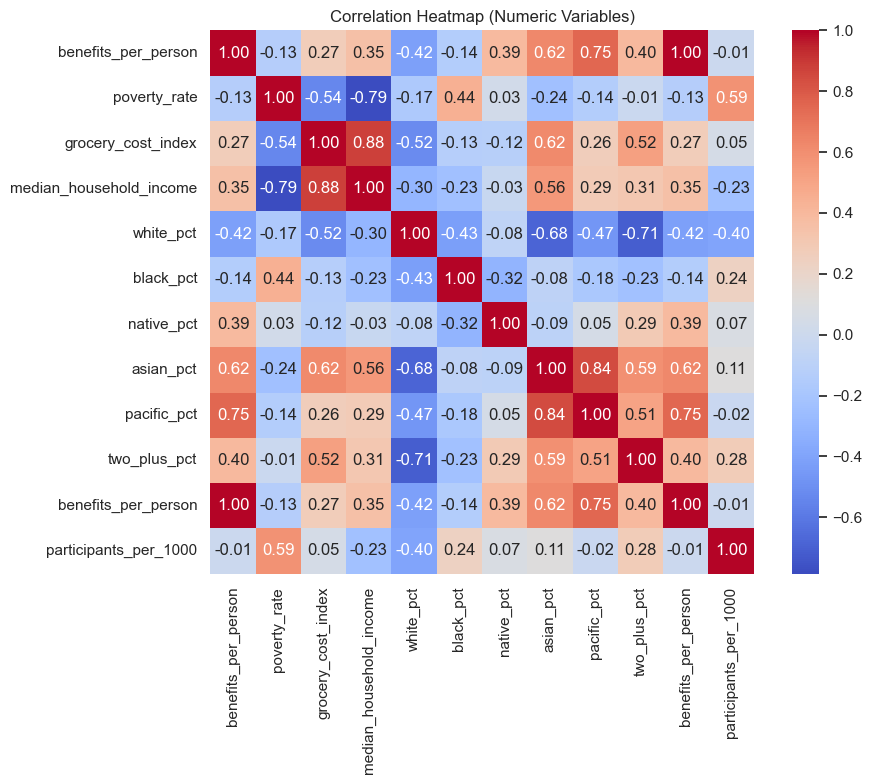

In [1501]:
## HEAT MAP

plt.figure(figsize=(10, 8))
corr = df[num_features + [target_reg, "participants_per_1000"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Numeric Variables)")
plt.tight_layout()
plt.show()


Predictors of SNAP Benefits:
benefits_per_person has strong positive correlations with asian_pct (0.62) and pacific_pct (0.75). This suggests states with larger Asian/Pacific Islander populations may have higher benefit levels (potentially due to cost-of-living or program eligibility differences).
benefits_per_person also correlates with median_household_income (0.35), likely because higher-income states have higher grocery costs (see grocery_cost_index vs. income correlation: 0.88).
Predictors of SNAP Participation:
participants_per_1000 correlates positively with poverty_rate (0.59) and negatively with median_household_income (-0.23)—intuitive, as lower-income/poverty-stricken states rely more on SNAP.
Multicollinearity Note:
asian_pct and pacific_pct are highly correlated (0.84), which may impact linear regression (addressed later with Ridge/Lasso regularization).

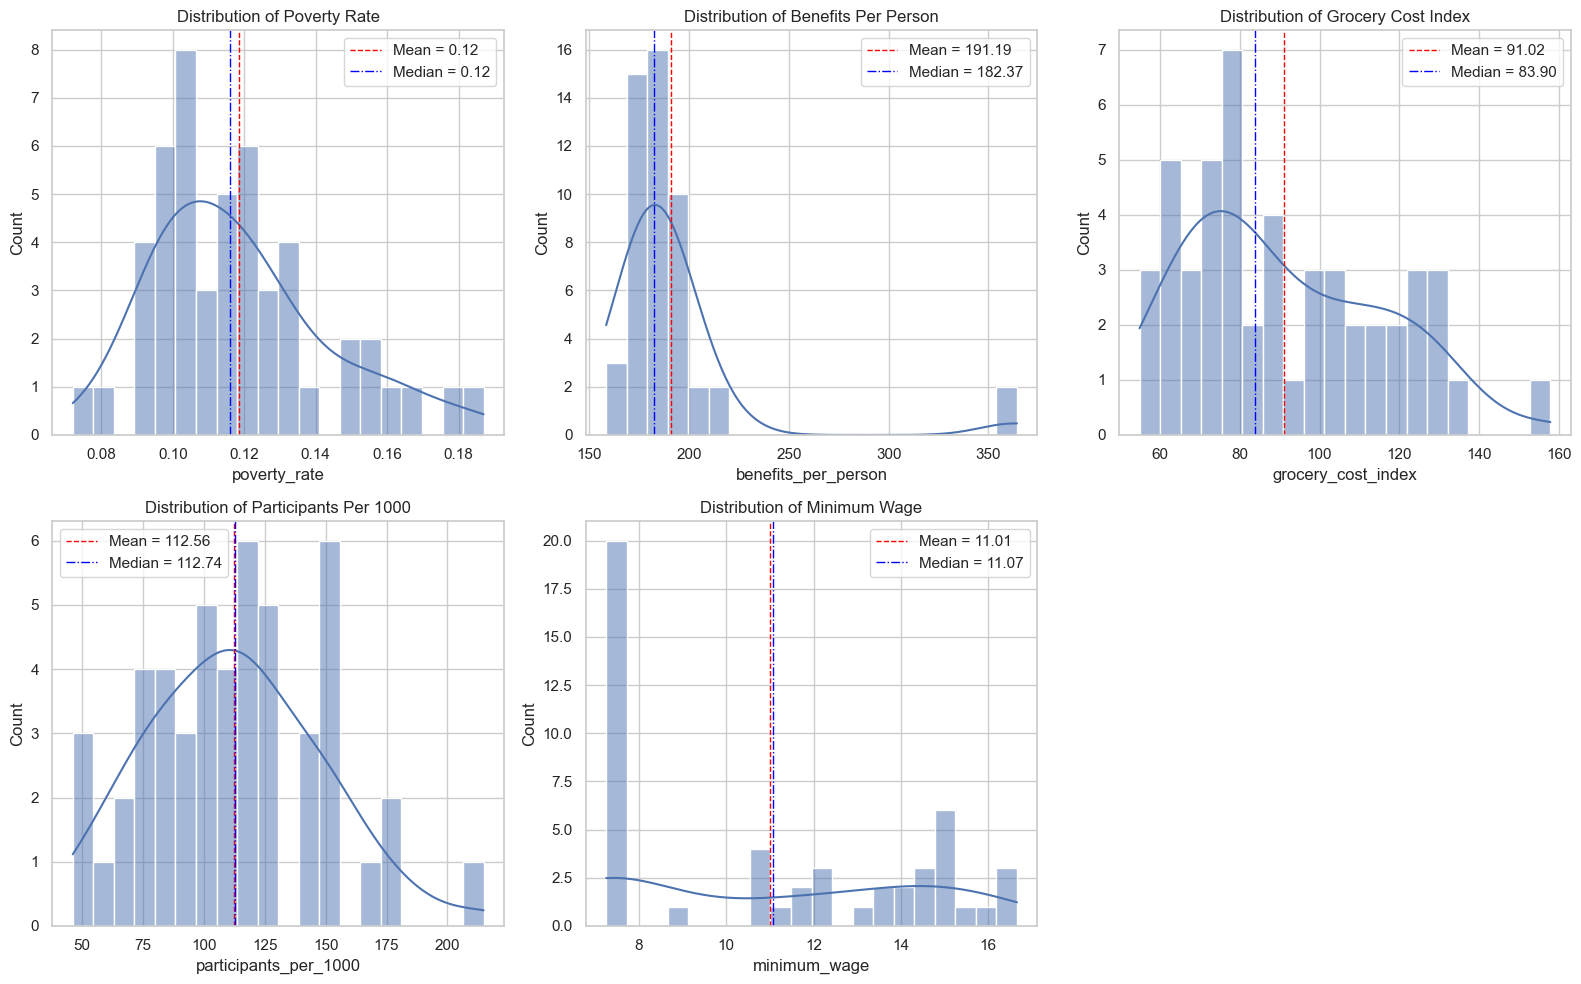

In [1502]:
# ============================================
# Hist.1 Visualization: Distribution of Key Variables
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(style="whitegrid")

# Variables
vars_to_plot = [
    "poverty_rate",
    "benefits_per_person",
    "grocery_cost_index",
    "participants_per_1000",
    "minimum_wage"
]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(vars_to_plot):
    ax = axes[idx]
    
    
    sns.histplot(
        df[col].dropna(),
        bins=20,
        kde=True,
        ax=ax
    )

    # Title
    ax.set_title(f"Distribution of {col.replace('_',' ').title()}", fontsize=12)

 
    mean_val = df[col].mean()
    median_val = df[col].median()

    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.2f}")
    ax.axvline(median_val, color="blue", linestyle="-.", linewidth=1, label=f"Median = {median_val:.2f}")
    
    # Legend
    ax.legend()

if len(vars_to_plot) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


*Hist.1 Observations*
- `Poverty_rate` is roughly normally distributed around 12%

- `benefits_per_person` is right-skewed, with most states between 
250

- `participants_per_1000` is also right-skewed, indicating most states have lower participation

- `minimum_wage` is bimodal, reflecting the divide between states following federal vs. higher state minimum wages This shows substantial variation in key economic and policy variables across states.

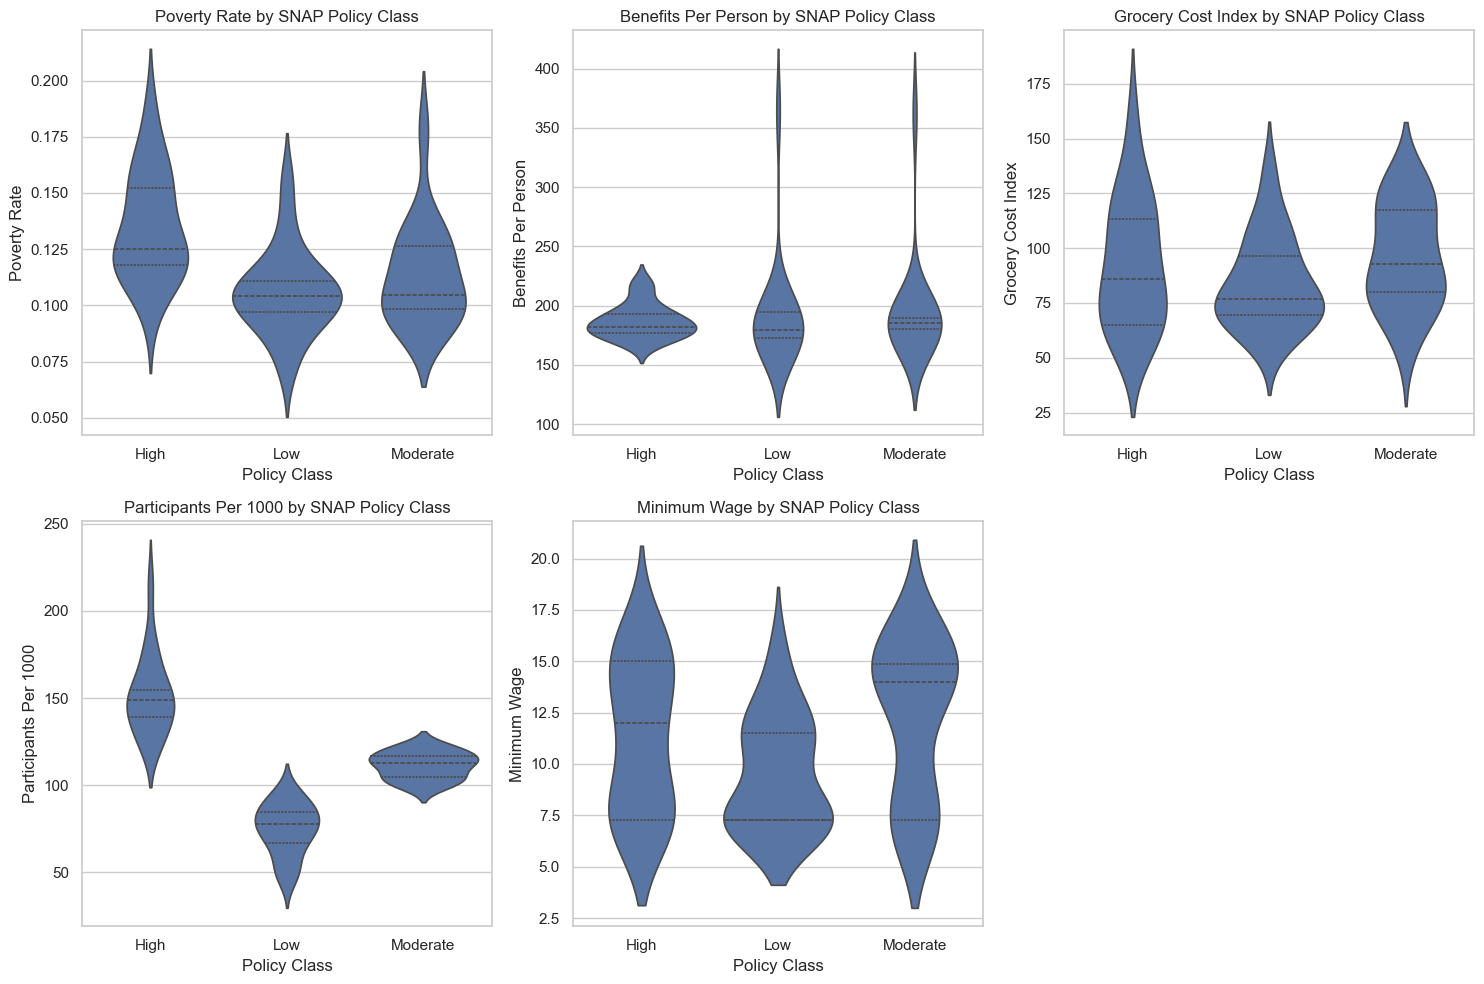

In [1503]:
#Violin PLOT 
plt.figure(figsize=(15, 10))

for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, x="snap_policy_class", y=col, inner="quartile")
    plt.title(f"{col.replace('_',' ').title()} by SNAP Policy Class", fontsize=12)
    plt.xlabel("Policy Class")
    plt.ylabel(col.replace("_", " ").title())

plt.tight_layout()
plt.show()



🎯 Main Takeaways (what you’d write in a paper)

SNAP Participants per 1000 is the strongest visual trend.
High policy states have much higher participation.

Minimum wage clearly increases with policy class.
Suggests broader anti-poverty frameworks.

Grocery cost index is higher in High policy states.
Policies may compensate for higher living costs.

Poverty rate does not strongly vary by policy class.
Mixed or weak relationship.

SNAP benefits per person don’t closely follow policy class labels.

/var/folders/2q/0pm84ptn56b3zt11wj9sryf80000gn/T/ipykernel_31116/1938874442.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




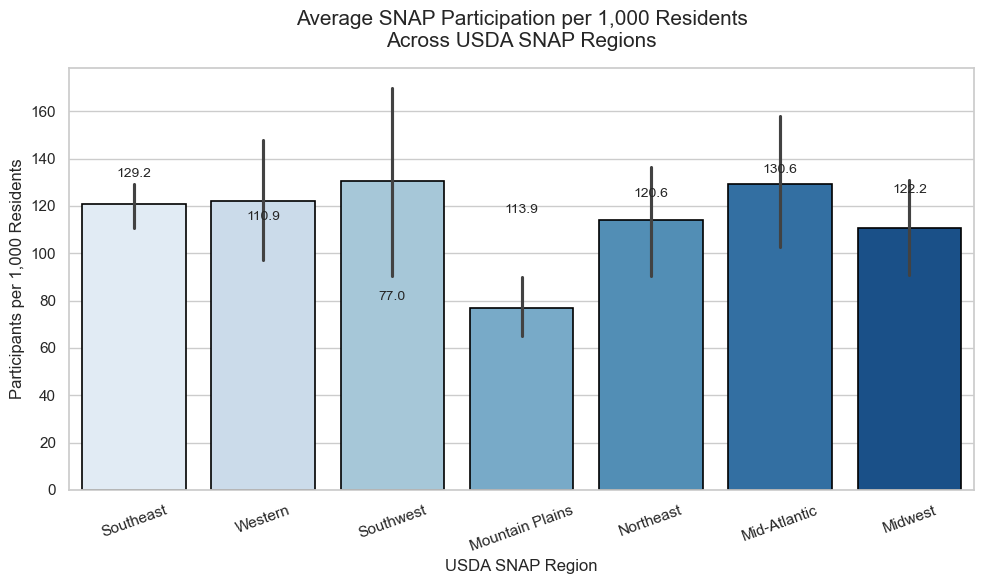

In [1504]:
# BAR PLOT
plt.figure(figsize=(10,6))

sns.barplot(
    data=final_master,
    x="usda_snap_region",
    y="participants_per_1000",
    estimator="mean",
    palette="Blues",
    edgecolor="black",
    linewidth=1.2
)

# Add value labels on top of bars (clean, not cluttered)
means = final_master.groupby("usda_snap_region")["participants_per_1000"].mean()
for i, value in enumerate(means):
    plt.text(
        i,
        value + 2,  # slight offset above the bar
        f"{value:.1f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("Average SNAP Participation per 1,000 Residents\nAcross USDA SNAP Regions", fontsize=15, pad=15)
plt.xlabel("USDA SNAP Region", fontsize=12)
plt.ylabel("Participants per 1,000 Residents", fontsize=12)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


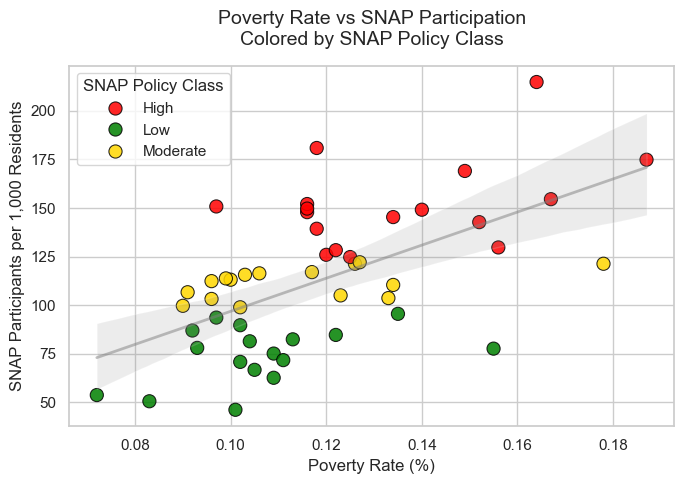

In [1505]:
## SCATTER 
plt.figure(figsize=(7,5))

palette = {
    "High": "red",
    "Moderate": "gold",
    "Low": "green"
}
sns.scatterplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    hue="snap_policy_class",
    palette=palette,
    s=90,
    alpha=0.85,
    edgecolor="black"
)

sns.regplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    scatter=False,
    color="gray",
    line_kws={"linewidth": 2, "alpha": 0.5}
)

plt.title("Poverty Rate vs SNAP Participation\nColored by SNAP Policy Class", fontsize=14, pad=15)
plt.xlabel("Poverty Rate (%)", fontsize=12)
plt.ylabel("SNAP Participants per 1,000 Residents", fontsize=12)

plt.legend(title="SNAP Policy Class")
plt.tight_layout()
plt.show()


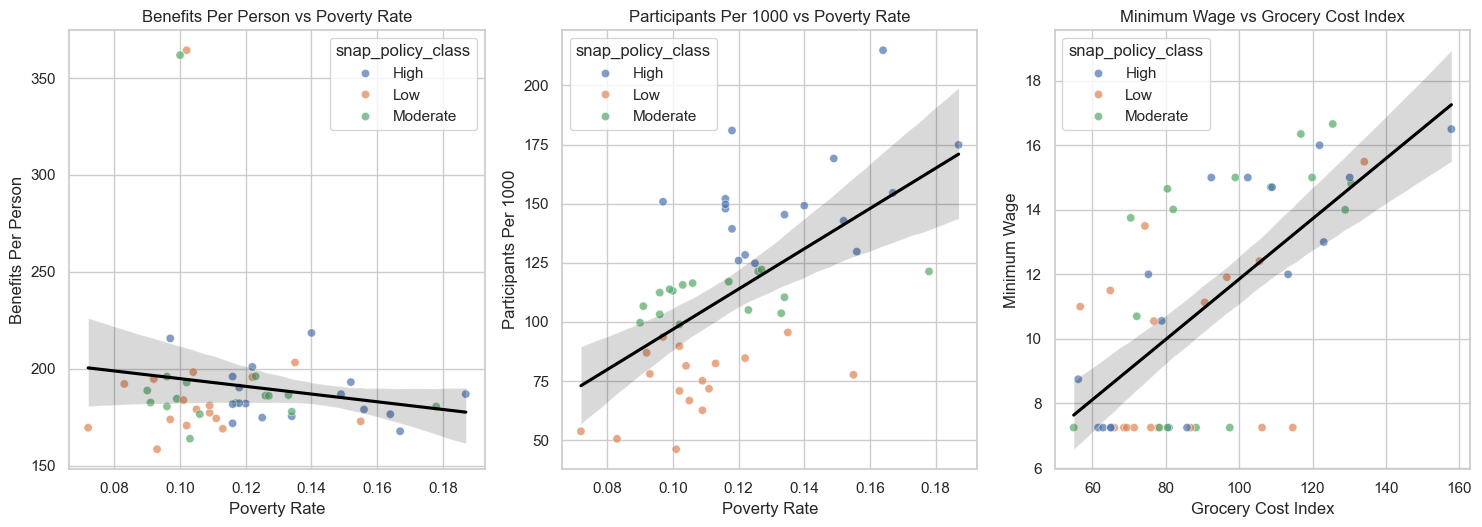

In [1506]:
pairs = [
    ("poverty_rate", "benefits_per_person"),
    ("poverty_rate", "participants_per_1000"),
    ("grocery_cost_index", "minimum_wage")
]

plt.figure(figsize=(15, 10))

for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=x, y=y, hue="snap_policy_class", alpha=0.7)
    sns.regplot(data=df, x=x, y=y, scatter=False, color="black")
    plt.title(f"{y.replace('_',' ').title()} vs {x.replace('_',' ').title()}")
    plt.xlabel(x.replace("_"," ").title())
    plt.ylabel(y.replace("_"," ").title())

plt.tight_layout()
plt.show()


# EDIT
SCATTERPLOT INTERPRETATION:

Clear positive relationship: as poverty increases, SNAP participation increases.

"High" policy states (red) cluster in high-poverty, high-participation areas.

"Low" policy states (blue) are concentrated in lower-participation regions.

This visually confirms that need (poverty) drives participation, but policy choices moderate the response.

<Figure size 1000x600 with 0 Axes>

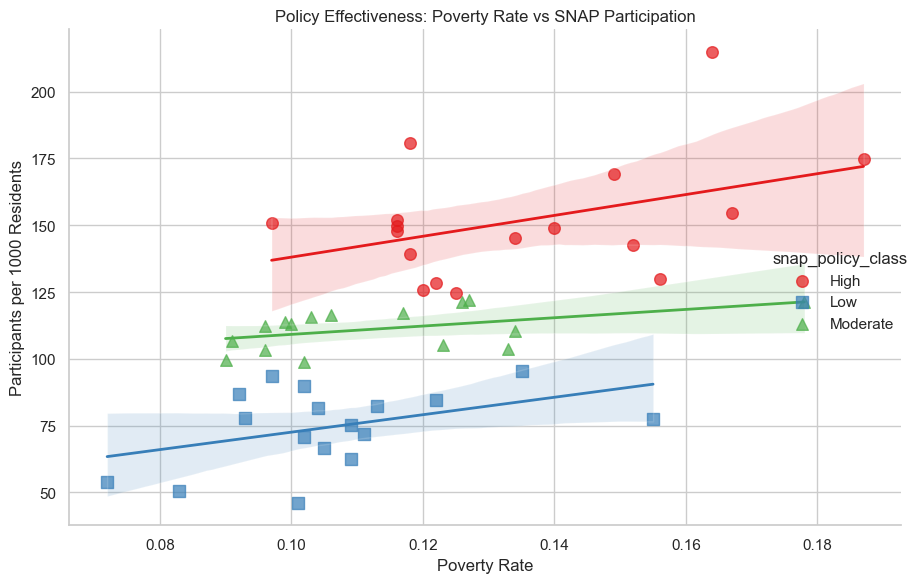

In [1507]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.lmplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    hue="snap_policy_class",
    markers=["o", "s", "^"],
    palette="Set1",
    height=6,
    aspect=1.3,
    scatter_kws={"alpha": 0.7, "s": 70},
    line_kws={"lw": 2}
)

plt.title("Policy Effectiveness: Poverty Rate vs SNAP Participation")
plt.xlabel("Poverty Rate")
plt.ylabel("Participants per 1000 Residents")
plt.tight_layout()
plt.show()


---------------------------------------------------------------------------------

# 4. Predicive Modeling Approaches




Then We split the data into **training** and **test** sets using a 70/30 split and preserve 
the class proportions with stratified sampling. All preprocessing (scaling numeric 
features and one-hot encoding categorical features) is handled inside a scikit-learn 
`Pipeline`.


In [1508]:
from sklearn.model_selection import train_test_split
# ----------------------------------------------------
# FOR REG
# ----------------------------------------------------
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_all, y_reg,
    test_size=0.3,
    random_state=42
)


In [1509]:
# ----------------------------------------------------
# FOR CLF
# ----------------------------------------------------
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)



In [1510]:
from sklearn.metrics import accuracy_score, log_loss

In [1511]:
# # ============================================
# # 
# # ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.3,
    random_state=42,
    stratify=y_clf
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        max_iter=500,
        solver="lbfgs"
    ))
])

log_reg_clf.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy:")
print("  Train:", log_reg_clf.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_clf.score(X_test_clf, y_test_clf))
proba_test = log_reg_clf.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy:
  Train: 0.9142857142857143
  Test : 0.4666666666666667
Log Loss:  0.9838741547404164


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



In [1512]:
# # ============================================
# # 
# # ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

log_reg_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty=None,
        max_iter=500,
        solver="lbfgs",
                ))
                
])

log_reg_ridge.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(No Penalty):")
print("  Train:", log_reg_ridge.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_ridge.score(X_test_clf, y_test_clf))
proba_test = log_reg_ridge.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy(No Penalty):
  Train: 1.0
  Test : 0.4
Log Loss:  14.762093911261024


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




# EDIT 
We created a multinomial logistic to predict the whether the states SNAP policy is considered high, low or, moderate. These classes were updated by dividing the participants per 1000 into thirds. States that head the least participants per 1000 were considered low, while states that had the most were considered high and those in the middle were moderate. We included all variables other than the target in this model and trained on 80% off the data. Since we had more than two classes, we had to do a multinominal regression. There were similar numbers of high, moderate, and low class in the data.

The log loss of our data is relatively small. This means that we can be confident in our predications because the probabilties leaned one way. For the most part, it was clear what class a state belonged in.

Both are training and test data were very accurate with scores of 1 and .6 respectively when we included no penanlty. Even though, we perfectly predicting the training data, our model is not very generalizable because it peformed much worse on our test data. We did regularzion-ridge, lasso, and, elastic net to address this.
“We used Multinomial Logistic Regression because our target variable (snap_policy_class) has three categories: Low, Moderate, and High.


Logistic Regression (GLM) – classify snap_policy_class
We created a multinomial logistic to predict the whether the states SNAP policy is considered high, low or, moderate. These classes were updated by dividing the participants per 1000 into thirds. States that head the least participants per 1000 were considered low, while states that had the most were considered high and those in the middle were moderate. We included all variables other than the target in this model and trained on 80% off the data. Since we had more than two classes, we had to do a multinominal regression. There were similar numbers of high, moderate, and low class in the data.



In [1513]:
# # ============================================
# # 
# # ============================================
cv_scores_log = cross_val_score(log_reg_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_log.mean(), "+/-", cv_scores_log.std())

CV accuracy (5-fold): 0.52 +/- 0.17204650534085256


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecat

In [ ]:
##UM WHAT HAPPWED TO THE CROSS VALIDATION   


We conducted a 5-fold cross validation so we could train on different subsets. Our average accuracy is the cross validation is a less, about 0.7, then the accuracy in our original train test split. The cross validation accuracy is a more stable estimate because we trained the model multiple times and on all the data. This suggests that the specfic model we trained on originally might just have been a good portion to train and test on. Still we want to regularize, to see if that will hel us reduce the RMSE.

### ✶ Regularization of Logistic Regression ✶

In [1514]:
# ============================================
# L1(LASSO) REGULARIZATION 
# ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.3,
    random_state=42,
    stratify=y_clf
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="l1",
        max_iter=500,
        solver="saga",
                ))
])

log_reg_clf.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(Lasso):")
print("  Train:", log_reg_clf.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_clf.score(X_test_clf, y_test_clf))
proba_test = log_reg_clf.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy(Lasso):
  Train: 0.8
  Test : 0.6666666666666666
Log Loss:  0.8966862280076199


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



In [1515]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

log_reg_ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="l2",
        max_iter=500,
        solver="lbfgs",
                ))
])

log_reg_ridge.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy(Ridge):")
print("  Train:", log_reg_ridge.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_ridge.score(X_test_clf, y_test_clf))
proba_test = log_reg_ridge.predict_proba(X_test_clf)
proba_test
print("Log Loss: ", log_loss(y_test_clf, proba_test))

Logistic Regression (multinomial) accuracy(Ridge):
  Train: 0.9
  Test : 0.5
Log Loss:  0.9852549136552662


/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



In [1516]:
# ============================================
# ELASTIC NET REGULARIZATION
# ============================================
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_all, y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

log_reg_elastic = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        multi_class="multinomial",
        penalty="elasticnet",
        max_iter=500,
        solver="saga",
        l1_ratio=0.5
                ))
])

log_reg_elastic.fit(X_train_clf, y_train_clf)

print("Logistic Regression (multinomial) accuracy (ElasticNet):")
print("  Train:", log_reg_elastic.score(X_train_clf, y_train_clf))
print("  Test :", log_reg_elastic.score(X_test_clf, y_test_clf))
proba_test = log_reg_elastic.predict_proba(X_test_clf)
print("Log Loss: ", log_loss(y_test_clf, proba_test))

/opt/miniconda3/envs/ds6001/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Logistic Regression (multinomial) accuracy (ElasticNet):
  Train: 0.825
  Test : 0.5
Log Loss:  0.8425592319329507



Regulriaztion of the multinomial logistic regression helped to improve the generalizabity of our model. In both lasso and elastic net regularization, our model actually had perfect accuracy on the test data and near perfect on the training data. When we included just a ridge penalty, our model still had 100% accuracy with the train data, but improved accuracy on the train data when compared to the training data. As for what regaularion peformed the best, we would choose the lasso because it perfomed really well on the test, but also had the lowest log loss.

It is interesting that our models were close to or at 100% for both training and test data. This means that the variables we included must be very good at predicting the snap policy class.



In [1517]:
# # ============================================
# # Random Forest Classifier
# # ============================================

# rf_clf = Pipeline([
#     ("prep", preprocessor),
#     ("clf", RandomForestClassifier(n_estimators=500, random_state=42))
# ])

# rf_clf.fit(X_train, y_train)
# y_pred_rf = rf_clf.predict(X_test)

# print("Random Forest Results:")
# print("Accuracy:", accuracy_score(y_test, y_pred_rf))
# print(classification_report(y_test, y_pred_rf))


In [1518]:
# # ============================================
# # Random Forest Feature Importances
# # ============================================

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract trained RF model
# rf_model = rf_clf.named_steps["clf"]

# # One-hot encoded column names
# ohe = preprocessor.named_transformers_["cat"]
# ohe_feature_names = ohe.get_feature_names_out(cat_features)

# # Combine
# feature_names = cat_features + list(ohe_feature_names)

# # Importance values
# importances = rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(10,6))
# sns.barplot(
#     y=np.array(feature_names)[indices],
#     x=importances[indices],
#     palette="viridis"
# )
# plt.title("Random Forest Feature Importance")
# plt.xlabel("Importance Score")
# plt.ylabel("Feature")
# plt.tight_layout()
# plt.show()


**Figure 2. Random Forest Feature Importances**

The random forest uses 500 trees and the same preprocessed feature set. On the test set:

Overall accuracy is notably higher than the logistic regression baseline.
Precision and recall are more balanced across the three classes (Low, Moderate, High), indicating better separation between categories.
Because the random forest can model nonlinear relationships and interactions, it is better suited to capturing the complex way in which economic conditions, demographics, and policy environment jointly relate to SNAP generosity.


This figure highlights which variables are most influential in predicting a state’s 
SNAP policy class. Core economic measures (such as poverty, income, and benefits per 
person), food price levels, and policy variables (minimum wage tier, SNAP region, 
and political trifecta) typically appear among the top drivers, with demographic 
composition providing additional explanatory power.


In [1519]:
# =========
# KNN
# =========

knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_clf.fit(X_train_clf, y_train_clf)

print("KNN accuracy:")
print("  Train:", knn_clf.score(X_train_clf, y_train_clf))
print("  Test :", knn_clf.score(X_test_clf, y_test_clf))

cv_scores_knn = cross_val_score(knn_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_knn.mean(), "+/-", cv_scores_knn.std())

KNN accuracy:
  Train: 0.575
  Test : 0.3
CV accuracy (5-fold): 0.42000000000000004 +/- 0.09797958971132713


Like with the previous model, we are trying to classify the SNAP policy level. We used a K-Nearest Neigbor model to classify this by looking at the five nearest neigbors. This model is moderatley accurate. Our test accuracy was .5 and our CV accuray was .5. This suggests while our KNN model is good for predicting class and Multinomial Logistic Regression may be better. This makes sense because each state is so different, it makes sense to look at each states individual characteristics rather than comparing between states. Overall, KNN is not an appropriate model for this dataset and performs worse than our regularized multinomial logistic regression models.

In [1520]:
knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5,weights='distance'))
])

knn_clf.fit(X_train_clf, y_train_clf)

print("KNN accuracy:")
print("  Train:", knn_clf.score(X_train_clf, y_train_clf))
print("  Test :", knn_clf.score(X_test_clf, y_test_clf))

cv_scores_knn = cross_val_score(knn_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_knn.mean(), "+/-", cv_scores_knn.std())

KNN accuracy:
  Train: 1.0
  Test : 0.3
CV accuracy (5-fold): 0.42000000000000004 +/- 0.116619037896906


In our original KNN classifier, we just looked at the closests neigbhors. We wanted to include the distance as weights to see if this made a difference. Included weights, woudld also be a good way to break ties. While the training data accuracy improved with including weights, both test accuracy and cross validation remained the same. The weights didn't not make a difference overall, which suggests that distance may not be a big factor in predicting class based on nearest neighors.

# Linear Regression not working 

In [1521]:
# ============================================
# Plain REGRESSION MODEL FITTINGN
# ============================================

preprocess=ColumnTransformer(transformers=[("encoder",OneHotEncoder(drop="first"),cat_features),
 ("numeric","passthrough",num_features)])


linreg=Pipeline(
    steps=[("preprocess",preprocess),
           ("model",LinearRegression())]
)

In [1522]:
vars=list(X_all.columns)
len(vars)

14

In [1523]:
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
linreg.fit(X_train_reg, y_train_reg)
# Getting the model
lin_model=linreg.named_steps['model']
feats=linreg.named_steps['preprocess'].get_feature_names_out()
coefs=lin_model.coef_.ravel()
coef_df=pd.DataFrame({"feature":feats,"coef":coefs})

y_pred_train = linreg.predict(X_train_reg)
y_pred_test  = linreg.predict(X_test_reg)
train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_pred_train))
test_rmse  = np.sqrt(mean_squared_error(y_test_reg,  y_pred_test))

print("Linear Regression:")
print("  Train RMSE:", train_rmse)
print("  Test  RMSE:", test_rmse)
print("  Train R^2:", r2_score(y_train_reg, y_pred_train))
print("  Test  R^2:", r2_score(y_test_reg,  y_pred_test))

Linear Regression:
  Train RMSE: 1.6917142810208246e-13
  Test  RMSE: 1.6637425550254792e-13
  Train R^2: 1.0
  Test  R^2: 1.0


In [1524]:
coef_df = coef_df.sort_values(by="coef", ascending=False)
print("\nTop Coefficients:")
print(coef_df.head(5))

print("\nBottom Coefficients:")
print(coef_df.tail(5))


Top Coefficients:
                         feature          coef
12  numeric__benefits_per_person  1.000000e+00
13         numeric__poverty_rate  1.888145e-12
20          numeric__pacific_pct  1.544921e-13
18           numeric__native_pct  8.188728e-14
19            numeric__asian_pct  4.489682e-14

Bottom Coefficients:
                                feature          coef
16                   numeric__white_pct -3.715138e-14
5   encoder__usda_snap_region_Southeast -3.770566e-14
11  encoder__rural_urban_category_urban -3.944186e-14
1     encoder__trifecta_2024_Republican -6.017582e-14
21                numeric__two_plus_pct -7.180410e-14


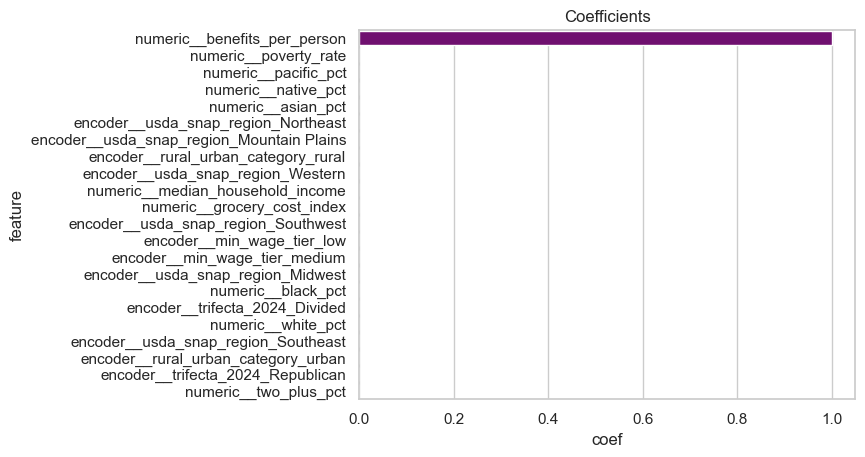

In [1525]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(coef_df,x='coef',y='feature',orient='h',color='purple',order=coef_df.sort_values(by='coef',ascending=False).feature)
plt.title("Coefficients")
plt.show()

# EDIT 
It seems that both the percent of Asians in the population and the percent of Pacific Islanders in the population have an great effect on the model. also snap usage in the Southwest 

In [1526]:
# CROSS VALIDATION FOR LINEAR REGRESSION
cv_scores_linreg=cross_val_score(linreg,X_all,y_reg,cv=5,scoring="neg_root_mean_squared_error")
print('cvscore:',cv_scores_linreg)
print("Linear CV RMSE (5-fold):",cv_scores_linreg.mean(),"+/-",cv_scores_linreg.std())

cvscore: [-5.47956995e-13 -8.13873900e-14 -4.40307229e-14 -9.51172327e-14
 -9.46916501e-14]
Linear CV RMSE (5-fold): -1.7263679821290696e-13 +/- 1.8858205466080792e-13


We did cross validation to get a better estimate of the RMSE. We noticed that the RMSE in the cross validation was higher the RMSE in or orignal fold. To see why, we looked at orginal folds and the second fold of data had a really high RMSE which contributed to the average RMSE. The other CV scores were lower. The train-test split we orignally split on was a good fold of the data.

In [1527]:
####LINEAR REGRESSION WITH LASSO REGULARIZATION

from sklearn.linear_model import Lasso

lasso = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Lasso(alpha=1.0, max_iter=5000))
])

lasso.fit(X_train_reg, y_train_reg)

y_pred_test_lasso = lasso.predict(X_test_reg)

lasso_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_lasso))
lasso_r2   = r2_score(y_test_reg, y_pred_test_lasso)

print("Lasso Regression:")
print("  Test RMSE:", lasso_rmse)
print("  Test R^2 :", lasso_r2)

Lasso Regression:
  Test RMSE: 0.39525155416296565
  Test R^2 : 0.9979961042711659


In [1528]:
## RIDGE REGRESSION
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

ridge = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=10.0))
])

ridge.fit(X_train_reg, y_train_reg)

ridge_model=ridge.named_steps['model']
feats=ridge.named_steps['preprocess'].get_feature_names_out()
coefs=ridge_model.coef_.ravel()
coef_df_ridge=pd.DataFrame({"feature":feats,"coef":coefs})

y_pred_test_ridge = ridge.predict(X_test_reg)

ridge_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_test_ridge))
ridge_r2   = r2_score(y_test_reg, y_pred_test_ridge)

print("Ridge Regression:")
print("  Test RMSE:", ridge_rmse)
print("  Test R^2 :", ridge_r2)

Ridge Regression:
  Test RMSE: 10.661443882941187
  Test R^2 : -0.458008304604695


In [1529]:
coef_df_ridge = coef_df_ridge.sort_values(by="coef", ascending=False)

print("\nTop Coefficients (Ridge):")
print(coef_df_ridge.head(5))

print("\nBottom Coefficients (Ridge):")
print(coef_df_ridge.tail(5))



Top Coefficients (Ridge):
                        feature       coef
0      num__benefits_per_person  21.896816
8              num__pacific_pct   7.926664
6               num__native_pct   7.314340
7                num__asian_pct   3.632461
3  num__median_household_income   2.942376

Bottom Coefficients (Ridge):
                            feature      coef
21           cat__min_wage_tier_low -1.321147
4                    num__white_pct -1.782901
11       cat__trifecta_2024_Divided -1.900679
23  cat__rural_urban_category_mixed -2.223339
18  cat__usda_snap_region_Southwest -2.583996


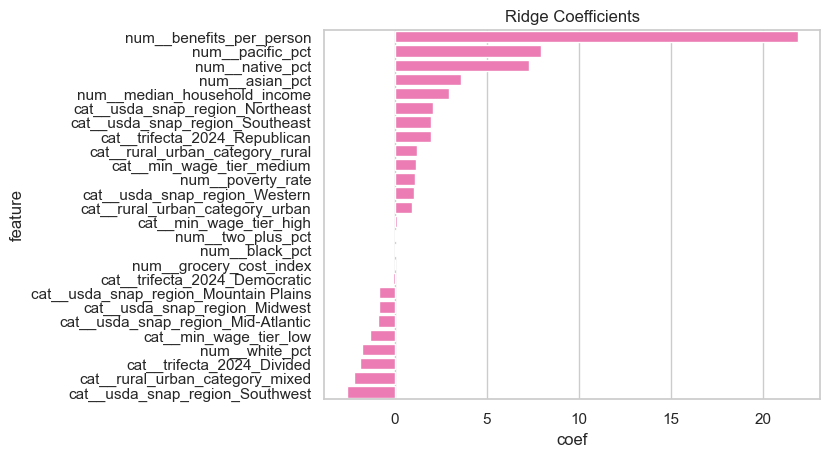

In [1530]:
from matplotlib import figure
sns.barplot(coef_df_ridge,x='coef',y='feature',order=coef_df_ridge.sort_values(by='coef',ascending=False).feature,orient='h',
            color='hotpink')
plt.title("Ridge Coefficients")
plt.show()

# 5. Unsupervised Learning 

In [1531]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
print("Numeric columns:", numeric_cols)


Numeric columns: ['fips_state', 'poverty_rate', 'median_household_income', 'white_pct', 'black_pct', 'native_pct', 'asian_pct', 'pacific_pct', 'two_plus_pct', 'grocery_cost_index', 'benefits_may_2025', 'participants_may_2025', 'benefits_per_person', 'minimum_wage', 'RUCC', 'population', 'participants_per_1000']


In [1532]:
from sklearn.preprocessing import StandardScaler
##SCALE
scaler = StandardScaler()
X = scaler.fit_transform(df[numeric_cols])

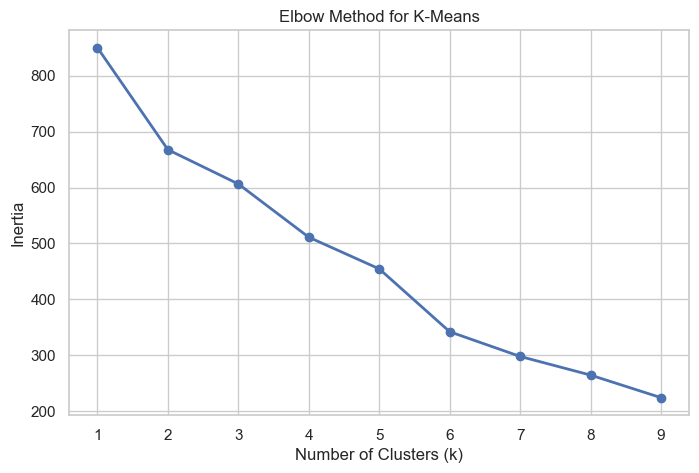

In [1533]:
##ELBOW 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker="o", linewidth=2)
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


In [1534]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [1535]:
cluster_summary = df.groupby("cluster")[numeric_cols].mean()
cluster_summary


,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,two_plus_pct,grocery_cost_index,benefits_may_2025,participants_may_2025,benefits_per_person,minimum_wage,RUCC,population,participants_per_1000
cluster,,,,,,,,,,,,,,,,,
0,8.500000,0.101000,98205.000000,0.403268,0.021342,0.072016,0.211081,0.056221,0.216742,112.766500,4.167980e+07,1.149765e+05,363.041316,12.955000,6.000000,1.093140e+06,101.397104
1,26.421053,0.113737,88946.789474,0.567382,0.117318,0.013962,0.066648,0.001828,0.145397,113.201684,2.630343e+08,1.381367e+06,188.668241,13.901053,3.473684,1.087218e+07,129.129631
2,32.655172,0.122759,74439.551724,0.757650,0.095789,0.013741,0.023228,0.001151,0.080957,74.989586,9.448944e+07,5.192998e+05,180.995408,8.986207,6.034483,4.505206e+06,102.471729


In [1536]:
## KMEANS FOR SNAP PARTICIPATION CLUSTERING

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Pick only numeric columns
X = df.select_dtypes(include=['float64', 'int64'])

# 2. Scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster_k3"] = kmeans.fit_predict(X_scaled)

# 4. Label clusters using participants_per_1000
anchor = "participants_per_1000"

cluster_means = df.groupby("cluster_k3")[anchor].mean().sort_values()

label_map = {
    cluster_means.index[0]: "Low",
    cluster_means.index[1]: "Medium",
    cluster_means.index[2]: "High"
}

df["cluster_label"] = df["cluster_k3"].map(label_map)

# 5. Show summary
print(df.groupby("cluster_label")[anchor].mean())


cluster_label
High      139.339133
Low       106.173174
Medium    123.003331
Name: participants_per_1000, dtype: float64


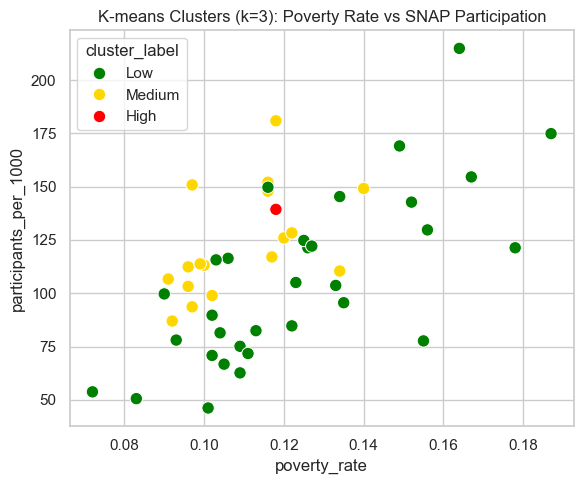

In [1537]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))

sns.scatterplot(
    data=df,
    x="poverty_rate",
    y="participants_per_1000",
    hue="cluster_label",      # Low / Medium / High
    palette={"Low": "green", "Medium": "gold", "High": "red"},  
    s=80
)

plt.title("K-means Clusters (k=3): Poverty Rate vs SNAP Participation")
plt.tight_layout()
plt.show()


In [1538]:
df[df.cluster_k3==2]

,state,state_abbr,fips_state,poverty_rate,median_household_income,white_pct,black_pct,native_pct,asian_pct,pacific_pct,...,minimum_wage,min_wage_tier,RUCC,rural_urban_category,population,participants_per_1000,snap_policy_class,cluster,cluster_k3,cluster_label
4,California,CA,6,0.118,100149,0.380758,0.053529,0.014224,0.161029,0.003952,...,16.5,high,2,urban,39431263.0,139.339133,High,1,2,High


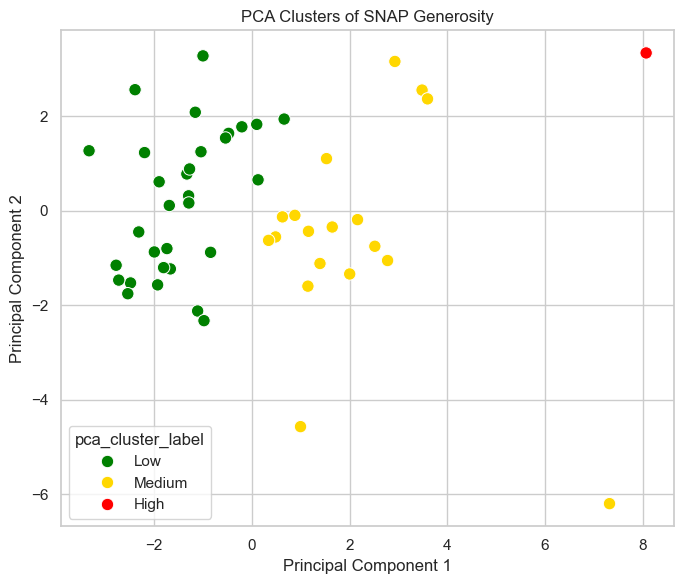

pca_cluster_label
High      139.339133
Low       106.705131
Medium    121.152175
Name: participants_per_1000, dtype: float64


In [1539]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select numeric columns
X = df.select_dtypes(include=['float64', 'int64'])

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA
pca = PCA(n_components=2)  # reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the dataframe
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# 4. Optional: cluster using PCA components (like K-means)
kmeans = KMeans(n_clusters=3, random_state=42)
df['pca_cluster'] = kmeans.fit_predict(X_pca)

# Label clusters based on participants_per_1000
anchor = 'participants_per_1000'
cluster_means = df.groupby('pca_cluster')[anchor].mean().sort_values()
label_map = {cluster_means.index[0]: 'Low', 
             cluster_means.index[1]: 'Medium', 
             cluster_means.index[2]: 'High'}
df['pca_cluster_label'] = df['pca_cluster'].map(label_map)

# 5. Visualize
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df,
    x='PC1',
    y='PC2',
    hue='pca_cluster_label',
    palette={'Low':'green', 'Medium':'gold', 'High':'red'},
    s=80
)
plt.title('PCA Clusters of SNAP Generosity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# 6. Optional: inspect mean participants per cluster
print(df.groupby('pca_cluster_label')[anchor].mean())




PCA reduces all numeric indicators (participants, benefits, spending, etc.) into principal components capturing most variation.

Clustering on the first two components groups states into Low, Medium, and High generosity.

This approach combines multiple variables into a single, consistent generosity measure while handling correlations.

Visualizing PC1 vs PC2 shows how states differ along key dimensions of SNAP generosity.

In [1540]:
#PCR

In [1541]:
##MLP NE1URAL NETWORK CLASSIFIER

mlp_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        max_iter=2000,
        random_state=42
    ))
])

mlp_clf.fit(X_train_clf, y_train_clf)

print("MLP accuracy:")
print("  Train:", mlp_clf.score(X_train_clf, y_train_clf))
print("  Test :", mlp_clf.score(X_test_clf, y_test_clf))

cv_scores_mlp = cross_val_score(mlp_clf, X_all, y_clf, cv=5)
print("CV accuracy (5-fold):", cv_scores_mlp.mean(), "+/-", cv_scores_mlp.std())

MLP accuracy:
  Train: 1.0
  Test : 0.6
CV accuracy (5-fold): 0.44000000000000006 +/- 0.10198039027185568


Need to add my interp 

## 𝟝. App/Dashboard 

## 𝟞. Conclusion and Policy Takeaways

In this project, we constructed a state-level view of SNAP generosity and modeled how 
economic, demographic, and policy factors relate to whether a state falls into a 
Low, Moderate, or High SNAP policy class.

**Key takeaways:**

- States with **higher SNAP participation per 1,000 residents** tend to share a mix of 
  higher economic need (higher poverty or lower income), policy decisions that support 
  higher benefit levels, and, in some cases, higher grocery costs that may necessitate 
  more generous support.

- **Policy levers matter.** Minimum wage tiers, political trifecta control, and SNAP 
  administrative regions show meaningful associations with the SNAP policy classes in 
  the random forest model. This suggests that institutional and political context helps 
  shape how generous SNAP ultimately is in practice.

- **Demographic composition contributes but is not the whole story.** Race shares help 
  explain some variation, but economic and policy factors remain important even after 
  controlling for demographics.

The analysis is cross-sectional and descriptive, so we cannot infer causality. However, 
it provides a compact framework for thinking about SNAP generosity as the outcome of 
interacting economic conditions and policy choices.

Future work could extend this by using panel data over time, adding state-level 
unemployment and housing cost measures, or exploring causal designs to separate 
policy effects from underlying economic need.
